In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# 自動找到專案根目錄（假設你專案資料夾叫這個名字）
project_root = Path("/Users/chenyungshan/Documents/data-projects/market-risk-early-warning")
os.chdir(project_root)
print("Working directory set to:", os.getcwd())

file_path ="data/raw/machine_learning_project.csv"
df =pd.read_csv(file_path, header=0)
#df = df.drop(index=range(0, 7)).reset_index(drop=True)
df.head()

Working directory set to: /Users/chenyungshan/Documents/data-projects/market-risk-early-warning


,Dates,SPX,VIX,move,10y_yield,2y_yield,3m,18m,put_call_ratio,rfsi,...,ism,initial_jobless_claims,bankruptcy_index,nonfarm,retail_sales_yoy,cpi_yoy,core_cpi_yoy,m2_yoy,housing_start,housing_sales
0,1/1/90,353.40,NaN,87.93,7.935,7.841,7.779,NaN,NaN,NaN,...,NaN,358.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/2/90,359.69,17.24,91.73,7.930,7.875,7.809,NaN,NaN,NaN,...,NaN,358.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/3/90,358.76,18.19,93.21,7.974,7.927,7.861,NaN,NaN,NaN,...,NaN,358.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/4/90,355.67,19.22,95.09,7.972,7.910,7.828,NaN,NaN,NaN,...,NaN,358.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/5/90,352.20,20.11,85.28,7.984,7.885,7.781,NaN,NaN,NaN,...,NaN,362.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


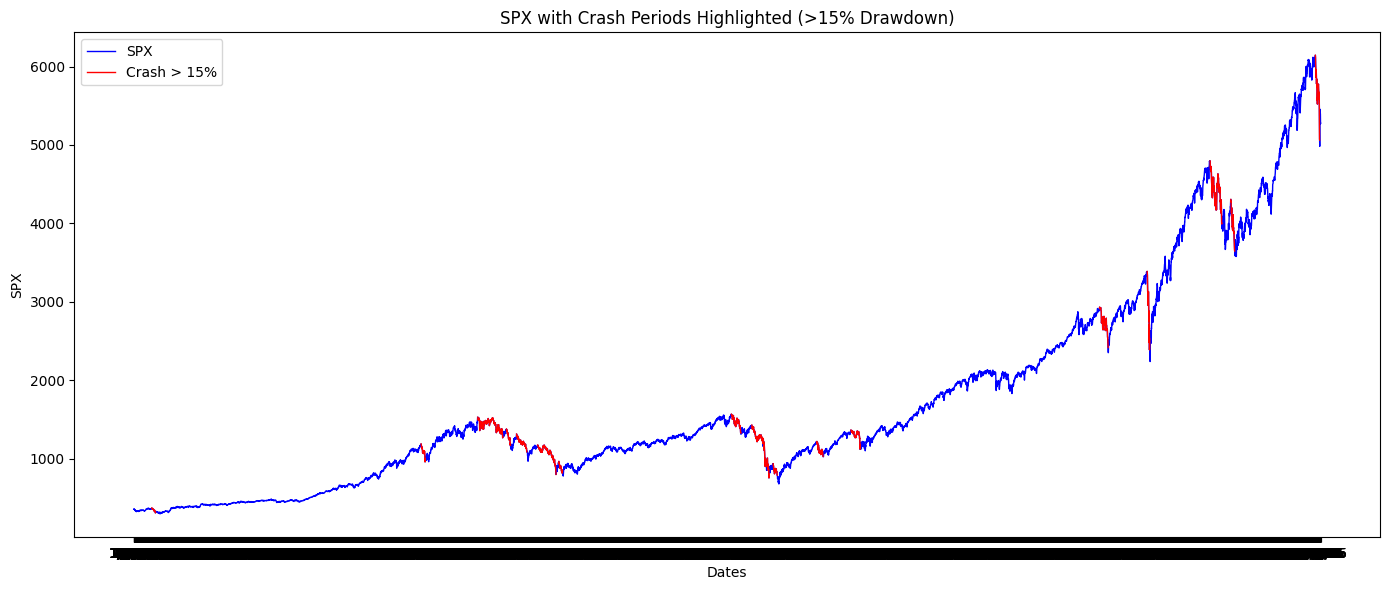

In [103]:


# Convert SPX to numeric
df['SPX'] = pd.to_numeric(df['SPX'], errors='coerce')

# Drop rows where SPX is NaN
df = df.dropna(subset=['SPX']).reset_index(drop=True)

# Add a Date index assuming business days from 1990-01-01
#df['Date'] = pd.date_range(start='1990-01-01', periods=len(df), freq='B')

# Calculate drawdowns
df['Peak'] = df['SPX'].cummax()
df['Drawdown'] = (df['SPX'] - df['Peak']) / df['Peak']

# Initialize crash label column
df['Crash_15pct'] = 0  # 重設標記
peak_idx = 0  # 初始峰頂

for i in range(1, len(df)):
    if df.loc[i, 'SPX'] > df.loc[peak_idx, 'SPX']:
        # 更新峰頂
        peak_idx = i
    drawdown = (df.loc[i, 'SPX'] - df.loc[peak_idx, 'SPX']) / df.loc[peak_idx, 'SPX']
    if drawdown <= -0.15:
        # 標記峰頂到谷底
        df.loc[peak_idx:i, 'Crash_15pct'] = 1
        # 如果到谷底（這段的最低點）
        if df.loc[i, 'SPX'] == df.loc[peak_idx:i, 'SPX'].min():
            # 更新峰頂為谷底
            peak_idx = i


import matplotlib.pyplot as plt

# 畫整條 SPX 線（藍色）
plt.figure(figsize=(14, 6))
plt.plot(df['Dates'], df['SPX'], label='SPX', linewidth=1, color='blue')

# 分段畫崩跌區（紅色）
in_crash = False
for i in range(len(df)):
    if df.loc[i, 'Crash_15pct'] == 1 and not in_crash:
        start_idx = i
        in_crash = True
    if (df.loc[i, 'Crash_15pct'] == 0 and in_crash) or (i == len(df) - 1 and in_crash):
        end_idx = i if df.loc[i, 'Crash_15pct'] == 0 else i
        plt.plot(df.loc[start_idx:end_idx, 'Dates'],
                 df.loc[start_idx:end_idx, 'SPX'],
                 color='red', linewidth=1)
        in_crash = False

plt.title('SPX with Crash Periods Highlighted (>15% Drawdown)')
plt.xlabel('Dates')
plt.ylabel('SPX')
plt.legend(['SPX', 'Crash > 15%'])
plt.tight_layout()
plt.show()



In [104]:
# 1. 利差
df['spread_10y_2y'] = df['10y_yield'] - df['2y_yield']
df['spread_10y_3m'] = df['10y_yield'] - df['3m']
df['spread_18m_3m'] = df['18m'] - df['3m']

# 2. 比率
df['copper_gold_ratio'] = df['copper'] / df['gold']
df['hy_ig_ratio'] = df['hy'] / df['ig']
df['dxy_gold_ratio'] = df['dxy'] / df['gold']
df['vix_move_ratio'] = df['VIX'] / df['move']

# 4. 經濟指標差距
df['cpi_core_diff'] = df['cpi_yoy'] - df['core_cpi_yoy']
df['m2_cpi_diff'] = df['m2_yoy'] - df['cpi_yoy']
df['ism_diff_50'] = df['ism'] - 50


def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI_14'] = compute_rsi(df['SPX'])

#df['MA_20'] = df['SPX'].rolling(20).mean()
#df['MA_60'] = df['SPX'].rolling(60).mean()
#df['MA_ratio'] = df['MA_20'] / df['MA_60']




# 補齊缺失值
df = df.ffill().fillna(0)

df.to_csv("./data/processed/risk_early_warning.csv", index=False)


In [105]:
print(df.columns.tolist())


['Dates', 'SPX', 'VIX', 'move', '10y_yield', '2y_yield', '3m', '18m', 'put_call_ratio', 'rfsi', 'rfsi_credit', 'gold', 'ig', 'hy', 'ig_cdx', 'hy_cdx', 'dxy', 'copper', 'iorb', 'sofr', 'ted_spread', 'ism', 'initial_jobless_claims', 'bankruptcy_index', 'nonfarm', 'retail_sales_yoy', 'cpi_yoy', 'core_cpi_yoy', 'm2_yoy', 'housing_start', 'housing_sales', 'Peak', 'Drawdown', 'Crash_15pct', 'spread_10y_2y', 'spread_10y_3m', 'spread_18m_3m', 'copper_gold_ratio', 'hy_ig_ratio', 'dxy_gold_ratio', 'vix_move_ratio', 'cpi_core_diff', 'm2_cpi_diff', 'ism_diff_50', 'RSI_14']


In [86]:
import numpy as np
import pandas as pd
from lppls import lppls

# 假設 df 已有 'Dates' 與 'SPX'

price_series = df[['Dates', 'SPX']].copy()
price_series['Dates'] = pd.to_datetime(price_series['Dates'], format='%m/%d/%y')
price_series.set_index('Dates', inplace=True)

window_size = 250
lppls_pos = []
lppls_neg = []

for i in range(len(price_series)):
    if i < window_size:
        lppls_pos.append(0)
        lppls_neg.append(0)
    else:
        sub_series = price_series.iloc[i - window_size:i]
        p = np.log(sub_series['SPX'].values).reshape(-1, 1)

        try:
            model = lppls.LPPLS(observations=p)
            model.fit(max_searches=50)

            # 取最佳擬合參數
            params = model.coef_
            t_c = params['tc']
            B = params['b']
            remaining_time = t_c - len(p)

            #if i % 50 == 0:  # 每 50 步印一次
            #    print(f"第{i}步: t_c={t_c}, B={B}, remaining_time={remaining_time}")

            # 判斷泡沫
            if B > 1e-4:
                lppls_pos.append(B * 1000)  # 放大強度
                lppls_neg.append(0)
            elif B < -1e-4:
                lppls_neg.append(abs(B) * 1000)
                lppls_pos.append(0)
            else:
                lppls_pos.append(0)
                lppls_neg.append(0)

        except:
            lppls_pos.append(0)
            lppls_neg.append(0)

df['lppls_pos'] = lppls_pos
df['lppls_neg'] = lppls_neg


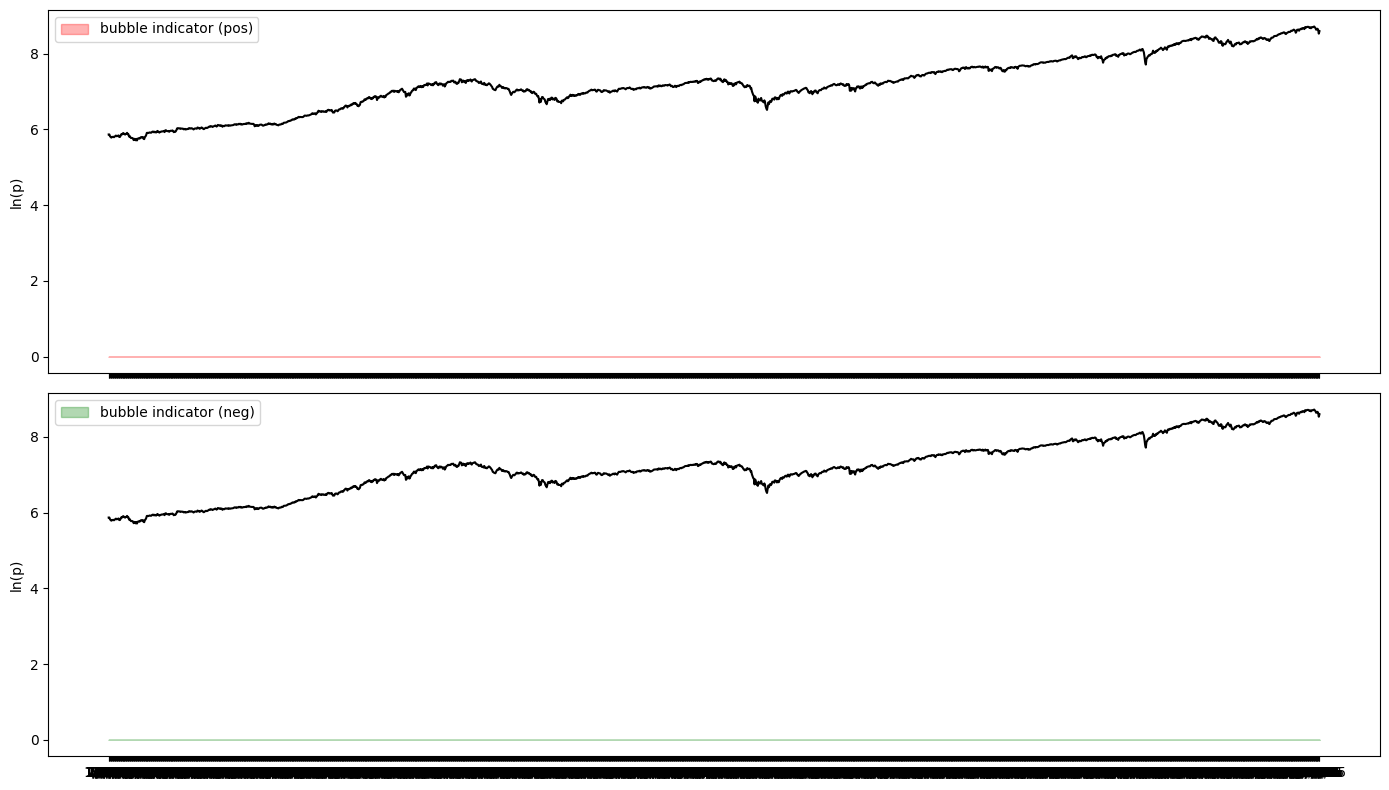

In [85]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 取樣（每5筆）
step = 5
dates = df['Dates'].values[::step]
log_spx = np.log(df['SPX'].values)[::step]
lppls_pos = df['lppls_pos'].values[::step]
lppls_neg = df['lppls_neg'].values[::step]

# 第一張：log(SPX) + 正泡沫
axs[0].plot(dates, log_spx, color='black')
axs[0].fill_between(dates, 0, lppls_pos, color='red', alpha=0.3, label='bubble indicator (pos)')
axs[0].set_ylabel('ln(p)')
axs[0].legend()

# 第二張：log(SPX) + 負泡沫
axs[1].plot(dates, log_spx, color='black')
axs[1].fill_between(dates, 0, lppls_neg, color='green', alpha=0.3, label='bubble indicator (neg)')
axs[1].set_ylabel('ln(p)')
axs[1].legend()

plt.tight_layout()
plt.show()


In [80]:
print(df[['lppls_pos', 'lppls_neg']].describe())

         lppls_pos    lppls_neg
count  9209.000000  9209.000000
mean      0.152444     0.026179
std       0.296114     0.278666
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.016486     0.000000
75%       0.191890     0.000000
max       8.771873    15.794864
